# Imports and downloads

In [1]:
import numpy as np
import pandas as pd
import warnings

In [228]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest, chi2

In [40]:
import nltk

In [41]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/iliav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iliav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iliav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iliav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [42]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.preprocessing import FunctionTransformer
import re

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [9]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.ticker as mticker

In [24]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [103]:
from IPython.display import clear_output

In [2]:
from datetime import datetime

current_time = datetime.now().strftime("%H:%M:%S")
print("Time started =", current_time)

Time started = 20:22:09


In [3]:
data = pd.read_csv("train.csv")

# EDA

In [4]:
data.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [6]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [7]:
na_counts(data)

keyword  location
False     7552      5080
True        61      2533

In [8]:
data = data.fillna("")

## Exploring variables

### Duplicates and mislabeled data
* I'm going to check only the `text` duplicates (i.e. even though `keyword` and `location` might differ).
* A record will be considered mislabeled if it has duplicates with different `target` value 

In [10]:
data.text.duplicated(keep=False).value_counts()

False    7434
True      179
Name: text, dtype: int64

In [11]:
data[data.text.duplicated(keep=False)].target.value_counts()

1    121
0     58
Name: target, dtype: int64

In [12]:
all_dups = data[data.duplicated(subset=['text'], keep=False)].text
all_dups.nunique()

69

In [13]:
mislabeled_dups = all_dups[all_dups.apply(lambda x: data[data.text==x].target.nunique()==2)]
data.iloc[mislabeled_dups.index].sort_values(by='text')[:10]

id    keyword                    location  \
4290  6094   hellfire    Jubail IC, Saudi Arabia.   
4299  6105   hellfire  ?????? ??? ?????? ????????   
4312  6123   hellfire          ?????? ???? ??????   
4244  6031  hazardous            New Delhi, Delhi   
4221  5996  hazardous                               
4239  6023  hazardous           Mysore, Karnataka   
2832  4076  displaced    Pedophile hunting ground   
2831  4072  displaced    Pedophile hunting ground   
2830  4068  displaced    Pedophile hunting ground   
2833  4077  displaced    Pedophile hunting ground   

                                                   text  target  
4290  #Allah describes piling up #wealth thinking it...       0  
4299  #Allah describes piling up #wealth thinking it...       0  
4312  #Allah describes piling up #wealth thinking it...       1  
4244  #foodscare #offers2go #NestleIndia slips into ...       0  
4221  #foodscare #offers2go #NestleIndia slips into ...       1  
4239  #foodscare #offers2go #NestleIndia slips into ...       1  
2832  .POTUS #StrategicPatience is a strategy for #G...       0  
2831  .POTUS #StrategicPatience is a strategy for #G...       1  
2830  .POTUS #StrategicPatience is a strategy for #G...       1  
2833  .POTUS #StrategicPatience is a strategy for #G...       1

In [14]:
data_no_mislabeled = data.drop(mislabeled_dups.index)
data_no_duplicated = data.drop_duplicates(subset=['text'], keep=False)

In [15]:
work_data = data_no_mislabeled 

* From now on I'll work with data cleaned from mislabeled items. We'll keep duplicates for now because we assume it reflects the real structure of the twitter data. Later we'll test if it has any effect on the results to clean all the duplicates

### Helpers

In [16]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = work_data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, work_data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [17]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = work_data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [18]:
work_data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [19]:
mutual_info_score(work_data['keyword'], work_data['target']), mutual_info_score(work_data['keyword'], shuffled_target)

(0.17132360315051776, 0.01667412695998024)

* The mutual info score of this variable and the target is pretty high comparing to the "shuffled" score, so it seems the prediction significance of this variable is high

In [20]:
sorted_corr_coefs(work_data, "keyword", "target")[:10], sorted_corr_coefs(work_data, "keyword", "target")[-10:]

([('keyword=derailment', 0.08302992384814313),
  ('keyword=wreckage', 0.08302992384814298),
  ('keyword=debris', 0.08086218013088244),
  ('keyword=outbreak', 0.08040918816372149),
  ('keyword=typhoon', 0.07817379537898307),
  ('keyword=oil%20spill', 0.07817379537898284),
  ('keyword=suicide%20bombing', 0.07229181842864764),
  ('keyword=suicide%20bomber', 0.06980413608593596),
  ('keyword=rescuers', 0.06682449786303161),
  ('keyword=suicide%20bomb', 0.06682449786303152)],
 [('keyword=explode', -0.05032173057874939),
  ('keyword=wrecked', -0.05127748262122846),
  ('keyword=traumatised', -0.05128953808511176),
  ('keyword=screaming', -0.05224239029628636),
  ('keyword=electrocute', -0.05244341052765653),
  ('keyword=body%20bag', -0.05338676579344253),
  ('keyword=blazing', -0.05431426121493636),
  ('keyword=ruin', -0.057009050576103566),
  ('keyword=aftershock', -0.058308609736542324),
  ('keyword=body%20bags', -0.06042093668166045)])

* It's hard to interpret correlation coefficients at this point. Hopefully it will be more clear after experiments

### Variable "location"

In [21]:
work_data.location.value_counts()

                          2503
USA                        104
New York                    71
United States               50
London                      45
                          ... 
Paulton, England             1
SEA Server                   1
todaysbigstock.com           1
buenos aires argentina       1
Lincoln                      1
Name: location, Length: 3329, dtype: int64

In [22]:
mutual_info_score(work_data['location'], work_data['target']), mutual_info_score(work_data['location'], shuffled_target)

(0.31411093454954364, 0.30039038689558417)

* Although the score seems pretty high, it doesn't differ much from the "shuffled" score, so probably the prediction significance of this var is low

In [23]:
sorted_corr_coefs(work_data, "location", "target")[:10], sorted_corr_coefs(work_data, "location", "target")[-10:]

([('location=USA', 0.05127865597035373),
  ('location=Mumbai', 0.04740569396538076),
  ('location=India', 0.046064880856544844),
  ('location=Nigeria', 0.04390256662704054),
  ('location=Washington, DC', 0.030385934048704856),
  ('location=Nairobi-KENYA', 0.026529183512312968),
  ('location=Bend, Oregon', 0.026529183512312888),
  ('location=Calgary', 0.02652918351231286),
  ('location=MAD as Hell', 0.026529183512312843),
  ('location=Sacramento', 0.02652918351231284)],
 [('location=Texas, USA', -0.022317363198970618),
  ('location=Leeds, England', -0.022317363198970635),
  ('location=Wisconsin', -0.02231736319897064),
  ('location=Coventry', -0.022317363198970652),
  ('location=ss', -0.024218473556252923),
  ('location=London, England', -0.024218473556252926),
  ('location=Morioh, Japan', -0.024449065050066745),
  ('location=Pennsylvania, USA', -0.026409757069899925),
  ('location=304', -0.02994981634009949),
  ('location=New York', -0.04013313127058214)])

### Variable "text"

In [25]:
count_vectorizer = CountVectorizer()
vectors = count_vectorizer.fit_transform(work_data['text'])
vectors.shape

(7558, 21612)

* We have 21612 features. There's probably lots of garbage in there. We'll clean it up with different techniques, starting with setting min_df for CountVectorizer, like this:

In [ ]:
CountVectorizer(min_df=10).fit_transform(work_data['text']).shape

(7558, 1544)

* Better now! Later we'll use dimensionality reduction technique to improve it

#### Hashtags

In [27]:
hashtag_pattern = r'#(\w+)'

hashtags = work_data.text.str.lower().str.findall(hashtag_pattern)
ht_c_vect = CountVectorizer(min_df=10, analyzer=lambda x: x)
ht_vectors = ht_c_vect.fit_transform(hashtags)
ht_c_vect.get_feature_names_out(), len(ht_c_vect.get_feature_names_out())

(array(['1', 'abstorm', 'africa', 'animalrescue', 'antioch', 'armageddon',
        'art', 'bb17', 'bbc', 'best', 'bestnaijamade', 'beyhive',
        'breaking', 'business', 'california', 'cnn', 'course', 'dance',
        'directioners', 'disaster', 'dnb', 'drought', 'dubstep',
        'earthquake', 'edm', 'emergency', 'emmerdale', 'fashion',
        'fukushima', 'gbbo', 'god', 'hailstorm', 'handbag', 'hiring',
        'hiroshima', 'hot', 'ices', 'india', 'iphone', 'irandeal', 'isis',
        'islam', 'japan', 'job', 'jobs', 'kerricktrial', 'kindle',
        'landslide', 'lgbt', 'libya', 'lies', 'mh370', 'military',
        'mtvhottest', 'mumbai', 'myanmar', 'news', 'newyork', 'nowplaying',
        'np', 'nuclear', 'nursing', 'okwx', 'pakistan', 'pantherattack',
        'phoenix', 'photography', 'prebreak', 'preparedness', 'quran',
        'refugees', 'rohingya', 'rt', 'science', 'seattle', 'sismo',
        'sittwe', 'socialnews', 'somalia', 'soundcloud', 'summerfate',
        'tbt', 't

##### Additional column
Let's create another column to keep hashtags apart from the rest of vectorized tokens

In [28]:
work_data['hashtags'] = hashtags
work_data

id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611  Police investigating after an e-bike collided ...       1   
7612  The Latest: More Homes Razed by Northern Calif...       1   

                 hashtags  
0            [earthquake]  
1                      []  
2                      []  
3             [wildfires]  
4     [alaska, wildfires]  
...                   ...  
7608                   []  
7609                   []  
7610                   []  
7611                   []  
7612                   []  

[7558 rows x 6 columns]

#### URLs

In [29]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [30]:
work_data.text[work_data.text.str.findall(url_pattern).apply(len) > 0].shape

(3965,)

Let's observe correlation of different words with target

In [31]:
columns = np.transpose(vectors.todense().A)

corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, work_data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [32]:
named_list[0:10], named_list[-10:]

([('http', 0.21452627610618558),
  ('co', 0.197184075655397),
  ('in', 0.1671580742879547),
  ('california', 0.1310149967949288),
  ('suicide', 0.12455801698077225),
  ('hiroshima', 0.1210916441867206),
  ('killed', 0.11979142932138698),
  ('mh370', 0.11002041366833958),
  ('wildfire', 0.10672655178990342),
  ('northern', 0.10654069392403501)],
 [('if', -0.06876362740044957),
  ('can', -0.07148314636945576),
  ('it', -0.07295391366915743),
  ('full', -0.07322194151418458),
  ('so', -0.07565381719162129),
  ('your', -0.0779455118166616),
  ('body', -0.08382709834151313),
  ('me', -0.08893371278948647),
  ('my', -0.12906704047732429),
  ('you', -0.15455528784196004)])

In [33]:
urls = work_data.text.str.lower().str.findall(url_pattern)
url_c_vect = CountVectorizer(min_df=3, analyzer=lambda x: x)
url_vectors = url_c_vect.fit_transform(urls)
url_c_vect.get_feature_names_out(), len(url_c_vect.get_feature_names_out())

(array(['http://t.co/0wratka2jl', 'http://t.co/9nwajli9cr',
        'http://t.co/bbdpnj8xsx', 'http://t.co/cedcugeuws',
        'http://t.co/cybksxhf7d', 'http://t.co/encmhz6y34',
        'http://t.co/ksawlyux02', 'http://t.co/lvlh3w3awo',
        'http://t.co/nnmqlz91o9', 'http://t.co/o91f3cyy0r',
        'http://t.co/q2eblokeve', 'http://t.co/qew4c5m1xd',
        'http://t.co/thoyhrhkfj', 'http://t.co/v3azwoamzk',
        'http://t.co/viwxy1xdyk', 'http://t.co/vvplfqv58p',
        'http://t.co/wvj39a3bgm', 'http://t.co/zujwuiomb3',
        'https://t.co/dehmym5lpk', 'https://t.co/e8dl1lncvu',
        'https://t.co/moll5vd8yd'], dtype=object),
 21)

##### Additional column
Let's create another column to keep hashtags apart from the rest of vectorized tokens

In [34]:
work_data['urls'] = urls

In [35]:
work_data

id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611  Police investigating after an e-bike collided ...       1   
7612  The Latest: More Homes Razed by Northern Calif...       1   

                 hashtags                      urls  
0            [earthquake]                        []  
1                      []                        []  
2                      []                        []  
3             [wildfires]                        []  
4     [alaska, wildfires]                        []  
...                   ...                       ...  
7608                   []  [http://t.co/stfmbbzfb5]  
7609                   []                        []  
7610                   []  [http://t.co/zdtoyd8ebj]  
7611                   []                        []  
7612                   []  [http://t.co/ymy4rskq3d]  

[7558 rows x 7 columns]

#### Emoji

In [36]:
import emoji

In [37]:
print(work_data.text.apply(emoji.distinct_emoji_list)[work_data.text.apply(emoji.emoji_count) > 0])

2171    [©]
2172    [©]
2173    [©]
2179    [©]
3479    [©]
4390    [©]
7127    [©]
7514    [©]
7527    [©]
7532    [©]
Name: text, dtype: object


### Target value counts

0    4313
1    3245
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x7f643978fdf0>,
 [Text(-0.24216139986342314, 1.0730134465216117, '0'),
  Text(0.242161399863423, -1.0730134465216117, '1')])

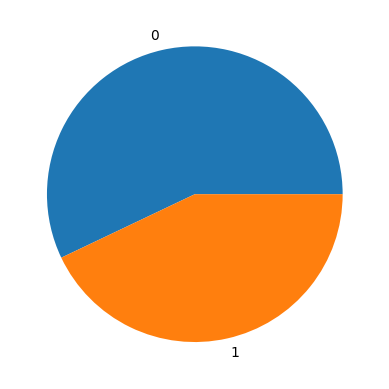

In [38]:
print(work_data.target.value_counts())
plt.pie(work_data.target.value_counts(), labels = (0,1))

* The data is somewhat imbalanced, so I need to keep an eye on using the proper settings for our models

# Training Models

## Plan

I'm going to try various data preparation and transformation steps and try them on several different classification models.
The whole pipeline will be as follows:

1. Data Preparation
    1. CountVectorizer applied to the `text` column as central part of preparation
    1. Additional steps:
        1. Cleanup URLs from text
        1. `keyword` column vectorization
        1. `location` column vectorization
        1. The newly created `hashtags` and `urls` columns vectorization
        1. Using stopwords
        1. Stemming
        1. Lemmatization
        1. ngrams
    1. By end of this stage I'll get a sparce matrix of vectors, that could be fed into different models. Testing different combinations I'll find the best steps for each model
1. Data transformation and dimensionality reduction
    1. The following techniques will be performed on the data from the previous stage:
        1. Polynomialization
        1. SelectKBest
        1. TruncatedSVD
    1. GridSearchCV will be used to find the most winning sequence
1. Final Models Parameters Tuning
    1. Each model with it's optimal data pipeline will be run through hyperparameter tuning
1. After each of the stages above I'll record the score on the test data to make possible overfitting visible

### Data Preparation Helpers and Transformers

In [236]:
from preprocess_util import k_range_scores, svd_n_range_scores, plot_k_range_results, plot_svd__range_results
from pipeline_util import make_poly2_k_best_pipeline

In [43]:
stopwords_english = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def pos_for_tag(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return('a')
        elif tag.startswith('R'):
            return('r')
        else:
            return('n')
        
def lemma_preprocessor_full(text):
    words=[lemmatizer.lemmatize(w, pos_for_tag(tag)) for w, tag in pos_tag(re.split("\\s+",text))]
    return ' '.join(words)

def stem_preprocessor(text):
    words=[stemmer.stem(w) for w in re.split("\\s+",text)]
    return ' '.join(words)

In [44]:
def url_clean(df):
    df = df.copy()
    df.text = df.text.replace(url_pattern, '', regex=True)
    return df

url_cleaner = FunctionTransformer(url_clean)

In [237]:
from pipeline_util import make_transformation_pipeline
def pipe_with_transformations(key):
    return make_transformation_pipeline(
        make_model(key),
        all_preparation_params[best_preparation_params[key]]
    )

In [89]:
def min_n_features(key, X=X_full_train, y=y_full_train):
    pipeline = make_preparation_pipeline(**all_preparation_params[best_preparation_params[key]])
    pipeline.fit(X, y)
    min_n = None
    for split in cv.split(X, y):
        n = pipeline.fit_transform(X.iloc[split[0]], y.iloc[split[0]]).shape[1]
        min_n = n if min_n is None else min(n, min_n)
            
    return min_n

### Train-Test Data Split

In [45]:
df_full_train, df_test = train_test_split(work_data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6046, 7), (1512, 7))

In [46]:
X_full_train = df_full_train.drop('target', axis=1)
y_full_train = df_full_train.target

X_test = df_test.drop('target', axis=1)
y_test = df_test.target

cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)

* X_full_train and y_full_train will be used for grid search and parameters tuning
* X_test and y_test will be only touched to test the tuned pipelines on different steps

In [112]:
# These data sets and cvs are used to quickly prototype a segment of data research. 
# In the end they shouldn't appear anywhere in this notebook 
small_train, small_test = train_test_split(work_data, test_size=0.9, random_state=42)
small_train.shape, small_test.shape

X_small = small_train.drop('target', axis=1)
y_small = small_train.target

cv_small_fast = [next(cv.split(X_small, y_small))]
cv_fast = [next(cv.split(X_full_train, y_full_train))]

## Data Preparation

### Steps combinations

The following preparation steps combinations were created after several iterations of the Data Preparation stage.
It would have been be too slow to test all possible combinations, so some trial and error approach was needed

In [51]:
all_preparation_params = {
    'Url Cleaner': {'url_cleaner': url_cleaner},
    'Stemming': {'preprocessor': stem_preprocessor},
    'Lemmatization': {'preprocessor': lemma_preprocessor_full},
    'Keyword': {'kw': True},
    'Location': {'loc': True},
    'Hashtags': {'hashtags': True},   
    'URLs': {'urls': True},
    'Stopwords': {'stopwords': stopwords_english},    
    '1-2 words ngrams': {'ngram_range': (1, 2)},
    '1-3 words ngrams': {'ngram_range': (1, 3)},

    'Stopwords + Stemming': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor},  
    'Stopwords + Lemmatization': {'stopwords': stopwords_english, 'preprocessor': lemma_preprocessor_full},
    'Keyword + URL Cleaner': {'url_cleaner': url_cleaner, 'kw': True},
    'Keyword + Stemming': {'url_cleaner': url_cleaner, 'preprocessor': stem_preprocessor},
    'Stopwords + URL Cleaner': {'stopwords': stopwords_english, 'url_cleaner': url_cleaner},
    'Stopwords + Keyword': {'stopwords': stopwords_english, 'kw': True},
    'Stopwords + Location': {'stopwords': stopwords_english, 'loc': True},
    'Stopwords + Hashtags': {'stopwords': stopwords_english, 'hashtags': True},
    'Stopwords + 1-2 ngrams': {'stopwords': stopwords_english, 'ngram_range': (1, 2)},
    'Stopwords + Stemming + Keyword': {'stopwords': stopwords_english, 'kw': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Location': {'stopwords': stopwords_english, 'loc': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Hashtags': {'stopwords': stopwords_english, 'hashtags': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + URL Cleaner': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'url_cleaner': url_cleaner},
    'Stopwords + Stemming + 1-2 ngrams': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'ngram_range': (1, 2)}, 
    'Keyword + Location': {'kw': True, 'loc': True},
    'Keyword + Hashtags': {'kw': True, 'hashtags': True},
    'Keyword + location + Hashtags': {'kw': True, 'hashtags': True, 'loc': True},
    'Keyword + Location + Stemming': {'kw': True, 
                                      'loc': True,
                                      'preprocessor': stem_preprocessor},
    'Keyword + Location + Hashtags + Stemming': {'kw': True,
                                                 'hashtags': True, 
                                                 'loc': True,
                                                 'preprocessor': stem_preprocessor}
}

### List of models

In [53]:
class Models:
    nb_key = 'Naive Bayes'
    rc_key = 'Ridge Classifier'
    lr_key = 'Logistic Regression'
    tree_key = 'Tree'
    forest_key = 'Forest'
    xgb_key = 'XGBoost'

In [52]:
# While majority of the models can handle it automatically or with a setting, XGBoost needs this to be set explicitly
scale_pos_weight = y_full_train.value_counts()[0] / y_full_train.value_counts()[1]

In [246]:
def make_model(key):
    match key:     
        case Models.nb_key:
            return ComplementNB() #This Naive Bayes classifier is meant to work well with imbalanced data sets
        case Models.rc_key:
            return RidgeClassifier(class_weight="balanced")
        case Models.lr_key:
            return LogisticRegression(class_weight="balanced", max_iter=500)
        case Models.tree_key:
            return DecisionTreeClassifier(class_weight="balanced")
        case Models.forest_key:
            return RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)
        case Models.xgb_key:
            return XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=0)

In [55]:
%%time
all_models_keys = [ 
        Models.nb_key, 
        Models.rc_key, 
        Models.lr_key, 
        Models.tree_key, 
        Models.forest_key, 
        Models.xgb_key
    ]

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 9.78 µs


In [57]:
from preprocess_util import plot_score_diffs

### Steps evaluation

In [238]:
from pipeline_util import make_preparation_pipeline

In [61]:
from sklearn.model_selection import cross_val_score

def evaluate_pipelines(pipelines, feature_key=None, with_test=True):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, pipeline in pipelines.items():
        steps = pipeline.steps.copy()
        if not any(step for step in steps if step[0] == 'classifier'):
            steps.append(('classifier', make_model(model_key)))
        clf_pipeline = Pipeline(steps)
        
        score = cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

        clf_pipeline.fit(X_full_train, y_full_train)
        record_dict[model_key] = score

        if with_test:
            test_score = f1_score(y_test, clf_pipeline.predict(X_test))
            test_record_dict[model_key] = test_score    
    
    scores_df = pd.DataFrame([record_dict])
    if with_test:
        scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [64]:
default_pipelines = {
    key: make_preparation_pipeline() for key in all_models_keys
}

In [65]:
default_scores_df = evaluate_pipelines(default_pipelines, feature_key='Default')

#### Default scores
These are scores for models with basic settings only trained on the vectorized `text` column without any preparation steps

In [66]:
default_scores_df

Naive Bayes  Ridge Classifier  Logistic Regression      Tree  \
Features                                                                        
Default (x_val)     0.733873          0.721860             0.734567  0.657304   
Default (test)      0.760383          0.758837             0.762422  0.681388   

                   Forest   XGBoost  
Features                             
Default (x_val)  0.700060  0.736132  
Default (test)   0.725849  0.742475

In [67]:
all_preparation_pipelines = {
    key: make_preparation_pipeline(**params) for key, params in all_preparation_params.items()
}

In [68]:
def xval_pipe_with_clf(pipeline, clf):
    steps = pipeline.steps.copy()
    steps.append(('classifier', clf))
    clf_pipeline = Pipeline(steps)

    return cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

In [69]:
def xval_pipes_and_models(pipelines, models_keys):
    df = pd.DataFrame()

    for key, pipeline in pipelines.items():
        record_dict = {model_key: xval_pipe_with_clf(pipeline, make_model(model_key)) for model_key in models_keys}
        record_dict['Features'] = key
        df = pd.concat([df, pd.DataFrame([record_dict])])

    df.set_index('Features', inplace=True)
    
    return df

In [70]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_preparation_scores = xval_pipes_and_models(all_preparation_pipelines, all_models_keys)

CPU times: user 10min 4s, sys: 7.06 s, total: 10min 11s
Wall time: 7min 20s


#### Preparation steps effect
Here are cross-validation score differences for various preparation steps combinations against the default pipeline

In [71]:
pd.concat([all_preparation_scores, default_scores_df])

Naive Bayes  Ridge Classifier  \
Features                                                                  
Url Cleaner                                  0.738323          0.720316   
Stemming                                     0.728849          0.721593   
Lemmatization                                0.713270          0.706847   
Keyword                                      0.748595          0.723676   
Location                                     0.731503          0.718256   
Hashtags                                     0.734102          0.722807   
URLs                                         0.733873          0.721860   
Stopwords                                    0.727567          0.724085   
1-2 words ngrams                             0.721602          0.710679   
1-3 words ngrams                             0.709014          0.708000   
Stopwords + Stemming                         0.721738          0.725003   
Stopwords + Lemmatization                    0.709694          0.703784   
Keyword + URL Cleaner                        0.747984          0.722447   
Keyword + Stemming                           0.736279          0.720083   
Stopwords + URL Cleaner                      0.726844          0.720137   
Stopwords + Keyword                          0.737590          0.721627   
Stopwords + Location                         0.726607          0.718187   
Stopwords + Hashtags                         0.726965          0.724845   
Stopwords + 1-2 ngrams                       0.720431          0.720337   
Stopwords + Stemming + Keyword               0.737638          0.728327   
Stopwords + Stemming + Location              0.723886          0.716993   
Stopwords + Stemming + Hashtags              0.722144          0.727089   
Stopwords + Stemming + URL Cleaner           0.727063          0.723178   
Stopwords + Stemming + 1-2 ngrams            0.717716          0.719273   
Keyword + Location                           0.745502          0.722995   
Keyword + Hashtags                           0.747019          0.724458   
Keyword + location + Hashtags                0.745760          0.722669   
Keyword + Location + Stemming                0.744360          0.719447   
Keyword + Location + Hashtags + Stemming     0.744600          0.721246   
Default (x_val)                              0.733873          0.721860   
Default (test)                               0.760383          0.758837   

                                          Logistic Regression      Tree  \
Features                                                                  
Url Cleaner                                          0.733242  0.666713   
Stemming                                             0.738845  0.676202   
Lemmatization                                        0.719422  0.633281   
Keyword                                              0.738634  0.667154   
Location                                             0.737130  0.669481   
Hashtags                                             0.734220  0.663065   
URLs                                                 0.734567  0.661149   
Stopwords                                            0.733207  0.687253   
1-2 words ngrams                                     0.733575  0.658752   
1-3 words ngrams                                     0.733187  0.663010   
Stopwords + Stemming                                 0.737075  0.680665   
Stopwords + Lemmatization                            0.714148  0.676342   
Keyword + URL Cleaner                                0.735559  0.672599   
Keyword + Stemming                                   0.738264  0.660803   
Stopwords + URL Cleaner                              0.730278  0.691047   
Stopwords + Keyword                                  0.736359  0.687933   
Stopwords + Location                                 0.735259  0.691814   
Stopwords + Hashtags                                 0.733629  0.686707   
Stopwords + 1-2 ngrams                               0.732611  0.6

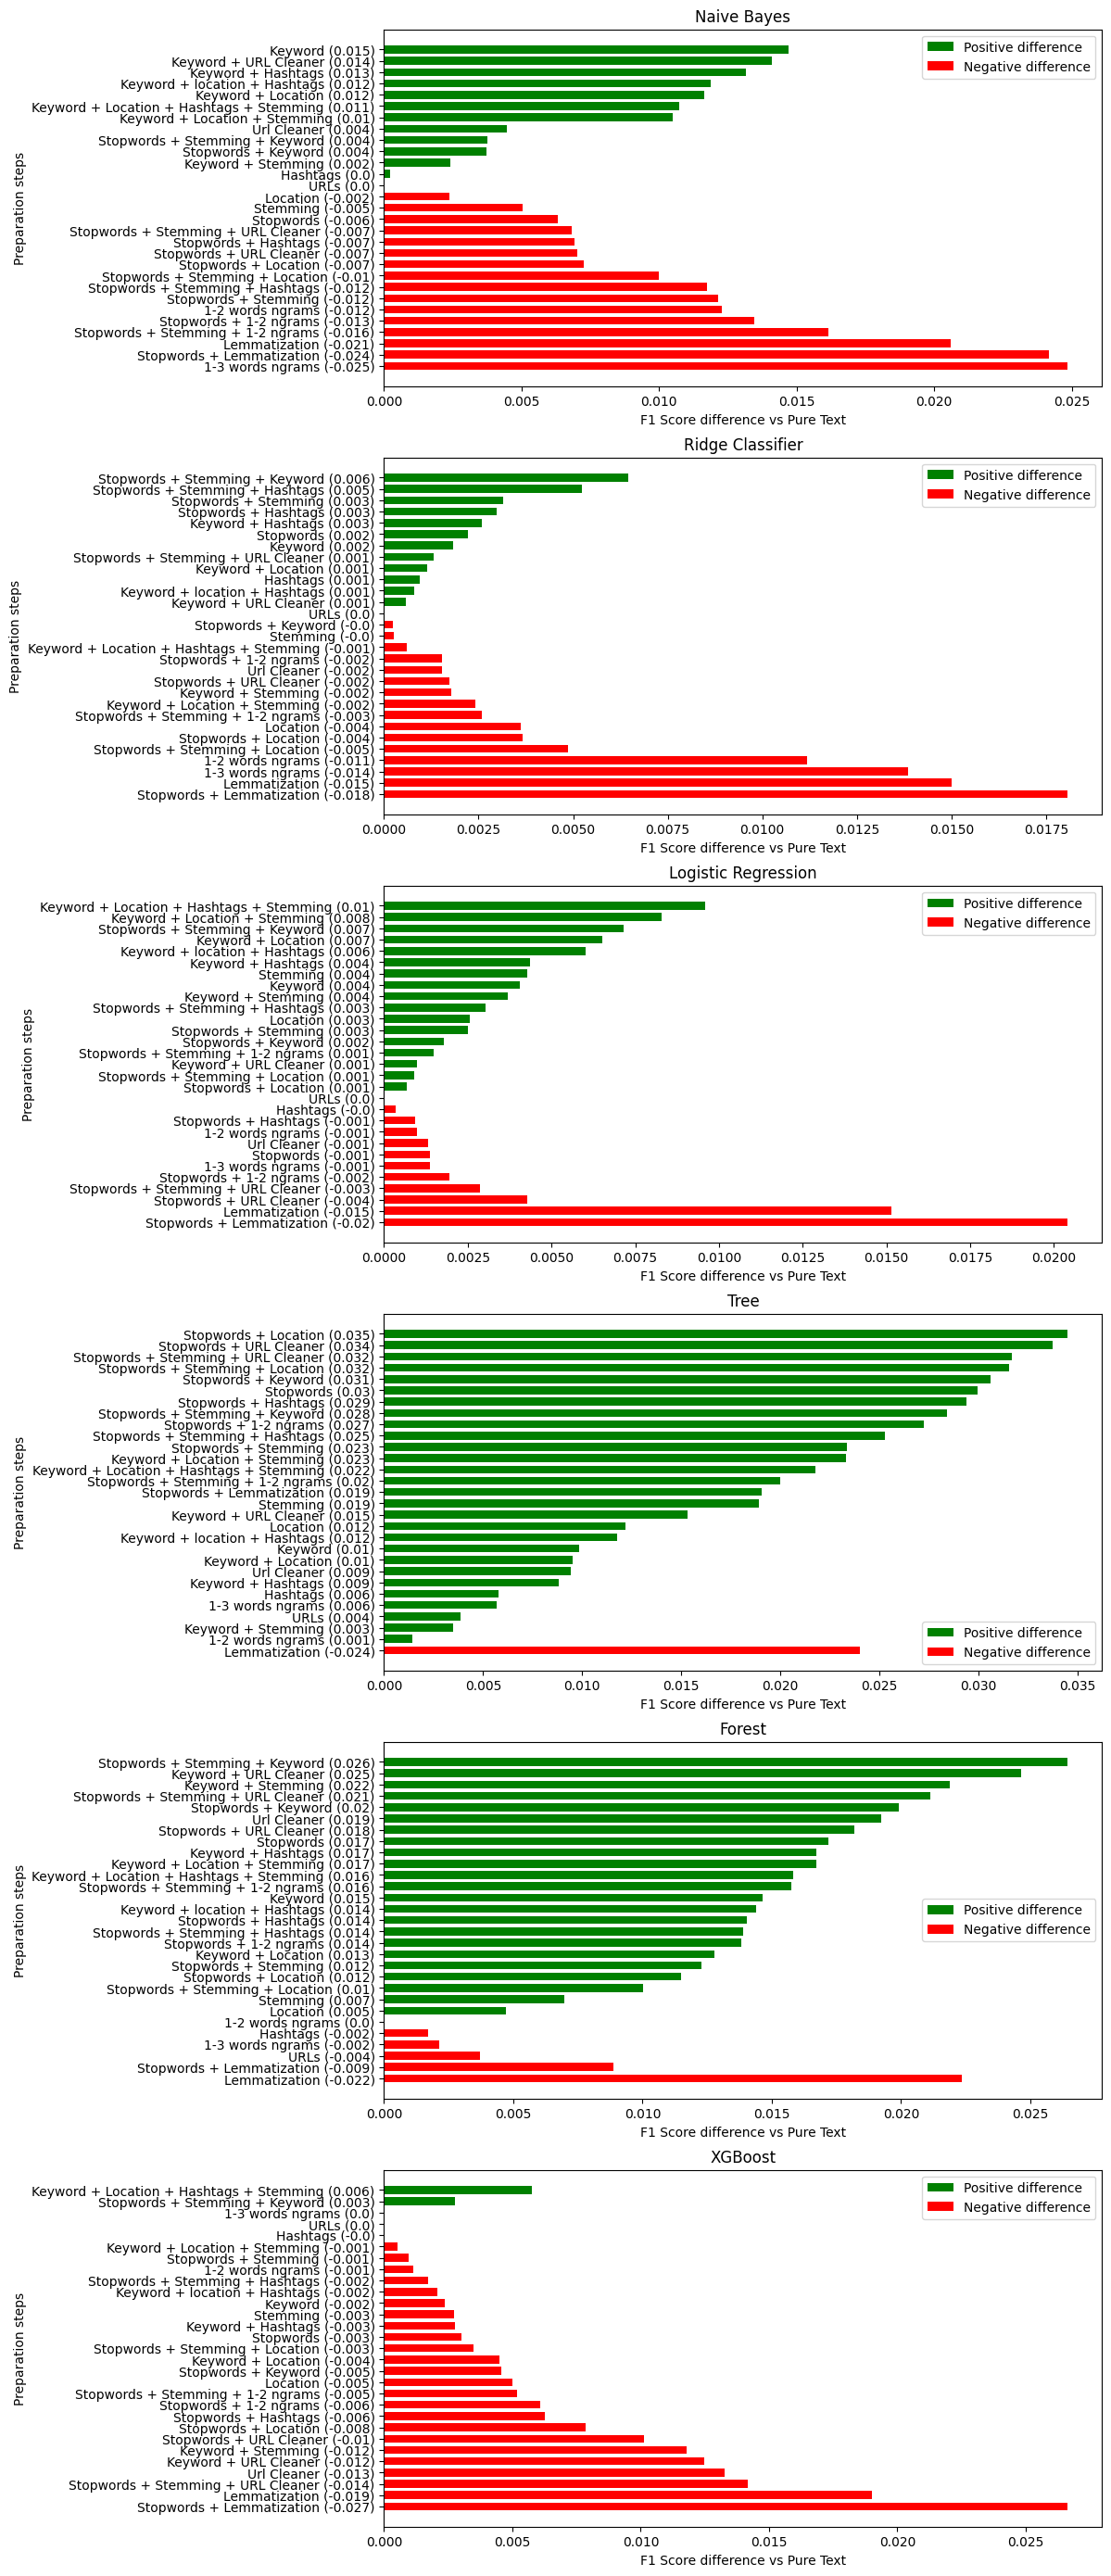

In [73]:
preparation_diffs = all_preparation_scores - default_scores_df.loc['Default (x_val)']
plot_score_diffs(preparation_diffs)

#### Best preparation parameters
Some of the differences are neglectible and are obviously just fluctuations. For now I'll just blindly take the best performing combinations, but later this needs more attention

In [74]:
best_preparation_params = preparation_diffs.idxmax()
best_preparation_params

Naive Bayes                                             Keyword
Ridge Classifier                 Stopwords + Stemming + Keyword
Logistic Regression    Keyword + Location + Hashtags + Stemming
Tree                                       Stopwords + Location
Forest                           Stopwords + Stemming + Keyword
XGBoost                Keyword + Location + Hashtags + Stemming
dtype: object

In [75]:
best_preparation_pipelines = {
    key: all_preparation_pipelines[params_key] for key, params_key in best_preparation_params.items()
}

#### Preparation scores

In [76]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preparation_scores_df = evaluate_pipelines(best_preparation_pipelines, feature_key='Data preparation')

CPU times: user 27.1 s, sys: 370 ms, total: 27.4 s
Wall time: 18 s


In [77]:
pd.concat((default_scores_df, preparation_scores_df))

Naive Bayes  Ridge Classifier  Logistic Regression  \
Features                                                                       
Default (x_val)              0.733873          0.721860             0.734567   
Default (test)               0.760383          0.758837             0.762422   
Data preparation (x_val)     0.748595          0.728327             0.744144   
Data preparation (test)      0.773688          0.762805             0.767677   

                              Tree    Forest   XGBoost  
Features                                                
Default (x_val)           0.657304  0.700060  0.736132  
Default (test)            0.681388  0.725849  0.742475  
Data preparation (x_val)  0.694481  0.723960  0.741877  
Data preparation (test)   0.709930  0.731466  0.759367

## Data Transformation. Polynomialization and Dimensionality Reduction

### Polynomial Features and SelectKBest with chi2 algorithm
* On this step we take the data from previous step and apply two different transformation to it:
1. Directly SelectKBest
1. First Polynomial Features and then SelectKBest on top of it
    1. The hypothesis behind using PolynomialFeatures is that some words might affect the meaning of the text in combination with the others. The idea is somewhat similar to using ngrams, but the words do not need to be placed next to each other, just to occur in the same text together
    1. The result of Polynomial Features is too high-dimensional, so it can't be used on it's own, hence we need to apply SelectKBest anyways
* Using knowledge of the number of features generated on the previous we'll build ranges for k and find the optimal values for cases with and without Polynomial Features

In [110]:
# this is helpful to create range of ks for SelectKBest transformer
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mins = {key: min_n_features(key) for key in all_models_keys}
    print(mins)

{'Naive Bayes': 1256, 'Ridge Classifier': 1128, 'Logistic Regression': 3427, 'Tree': 3063, 'Forest': 1128, 'XGBoost': 3427}


In [118]:
# these ranges where obtained after couple iterations
k_ranges_dict = {
    Models.nb_key: np.concatenate(
                            (np.linspace(400, 1100, 5, dtype=int),
                            np.linspace(5000, 15000, 3, dtype=int))),
    Models.rc_key:  np.concatenate(
                            (np.linspace(400, 1100, 5, dtype=int),
                             np.linspace(2500, 7000, 3, dtype=int))),
    Models.lr_key:  np.concatenate(
                            (np.linspace(600, 1100, 6, dtype=int),
                             np.linspace(2000, 7000, 3, dtype=int))),
    Models.tree_key: np.concatenate(
                            (np.linspace(500, 1000, 5, dtype=int),
                            np.linspace(2000, 7000, 6, dtype=int))),
    Models.forest_key: np.concatenate(
                            (np.linspace(600, 1100, 6, dtype=int),
                             np.linspace(2000, 7000, 6, dtype=int))),
    Models.xgb_key: np.concatenate(
                            (np.linspace(2000, 3000, 5, dtype=int),
                            np.linspace(4000, 6000, 3, dtype=int))),
}

In [ ]:
%%time
k_ranged_pipelines = {
    k: (pipe_with_transformations(k),
        k_ranges_dict[k])  
    for k in all_models_keys
}

k_range_results = k_range_scores(k_ranged_pipelines, cv=cv, X=X_full_train, y=y_full_train)

Started Naive Bayes at 21:21:11
Started Ridge Classifier at 21:24:26
Started Logistic Regression at 21:27:44
Started Tree at 21:57:26
Started Forest at 22:26:11
Started XGBoost at 22:31:44
CPU times: user 1h 39min 23s, sys: 2min 5s, total: 1h 41min 28s
Wall time: 1h 37min 17s


In [123]:
xgb_tree_k_ranges_dict = {
        Models.tree_key: np.concatenate(
                            (np.linspace(200, 1000, 9, dtype=int),
                            np.linspace(2000, 8000, 5, dtype=int))),    
        Models.xgb_key: np.concatenate(
                            (np.linspace(1000, 3000, 7, dtype=int),
                            np.linspace(4000, 7000, 3, dtype=int)))
}

In [124]:
%%time
xgb_tree_k_ranged_pipelines = {
    k: (pipe_with_transformations(k),
        xgb_tree_k_ranges_dict[k])  
    for k in xgb_tree_k_ranges_dict.keys()
}

xgb_tree_k_range_results = k_range_scores(xgb_tree_k_ranged_pipelines, cv=cv, X=X_full_train, y=y_full_train)

Started Tree at 23:10:31
Started XGBoost at 23:47:54
CPU times: user 1h 13min 43s, sys: 58 s, total: 1h 14min 41s
Wall time: 1h 10min 35s


In [130]:
xgb_tree_results = k_range_results.copy()
xgb_tree_results.update(xgb_tree_k_range_results)

In [116]:
# %%time
# k_ranged_pipelines = {
#     k: (pipe_with_transformations(k),
#         k_ranges_dict[k])  
#     for k in all_models_keys
# }

# k_range_results = k_range_scores(k_ranged_pipelines, cv=cv_fast, X=X_full_train, y=y_full_train)
# clear_output(wait=True)

CPU times: user 22min, sys: 27.4 s, total: 22min 27s
Wall time: 21min 30s


In [ ]:
Started Naive Bayes at 20:49:48
Started Ridge Classifier at 20:50:38
Started Logistic Regression at 20:51:30
Started Tree at 20:58:13
Started Forest at 21:03:30
Started XGBoost at 21:04:29

#### Visualization
* The Default horizontal line shows the best score right after the Data Preparation stage, i.e. without any polynomialization or dimensionality reduction 

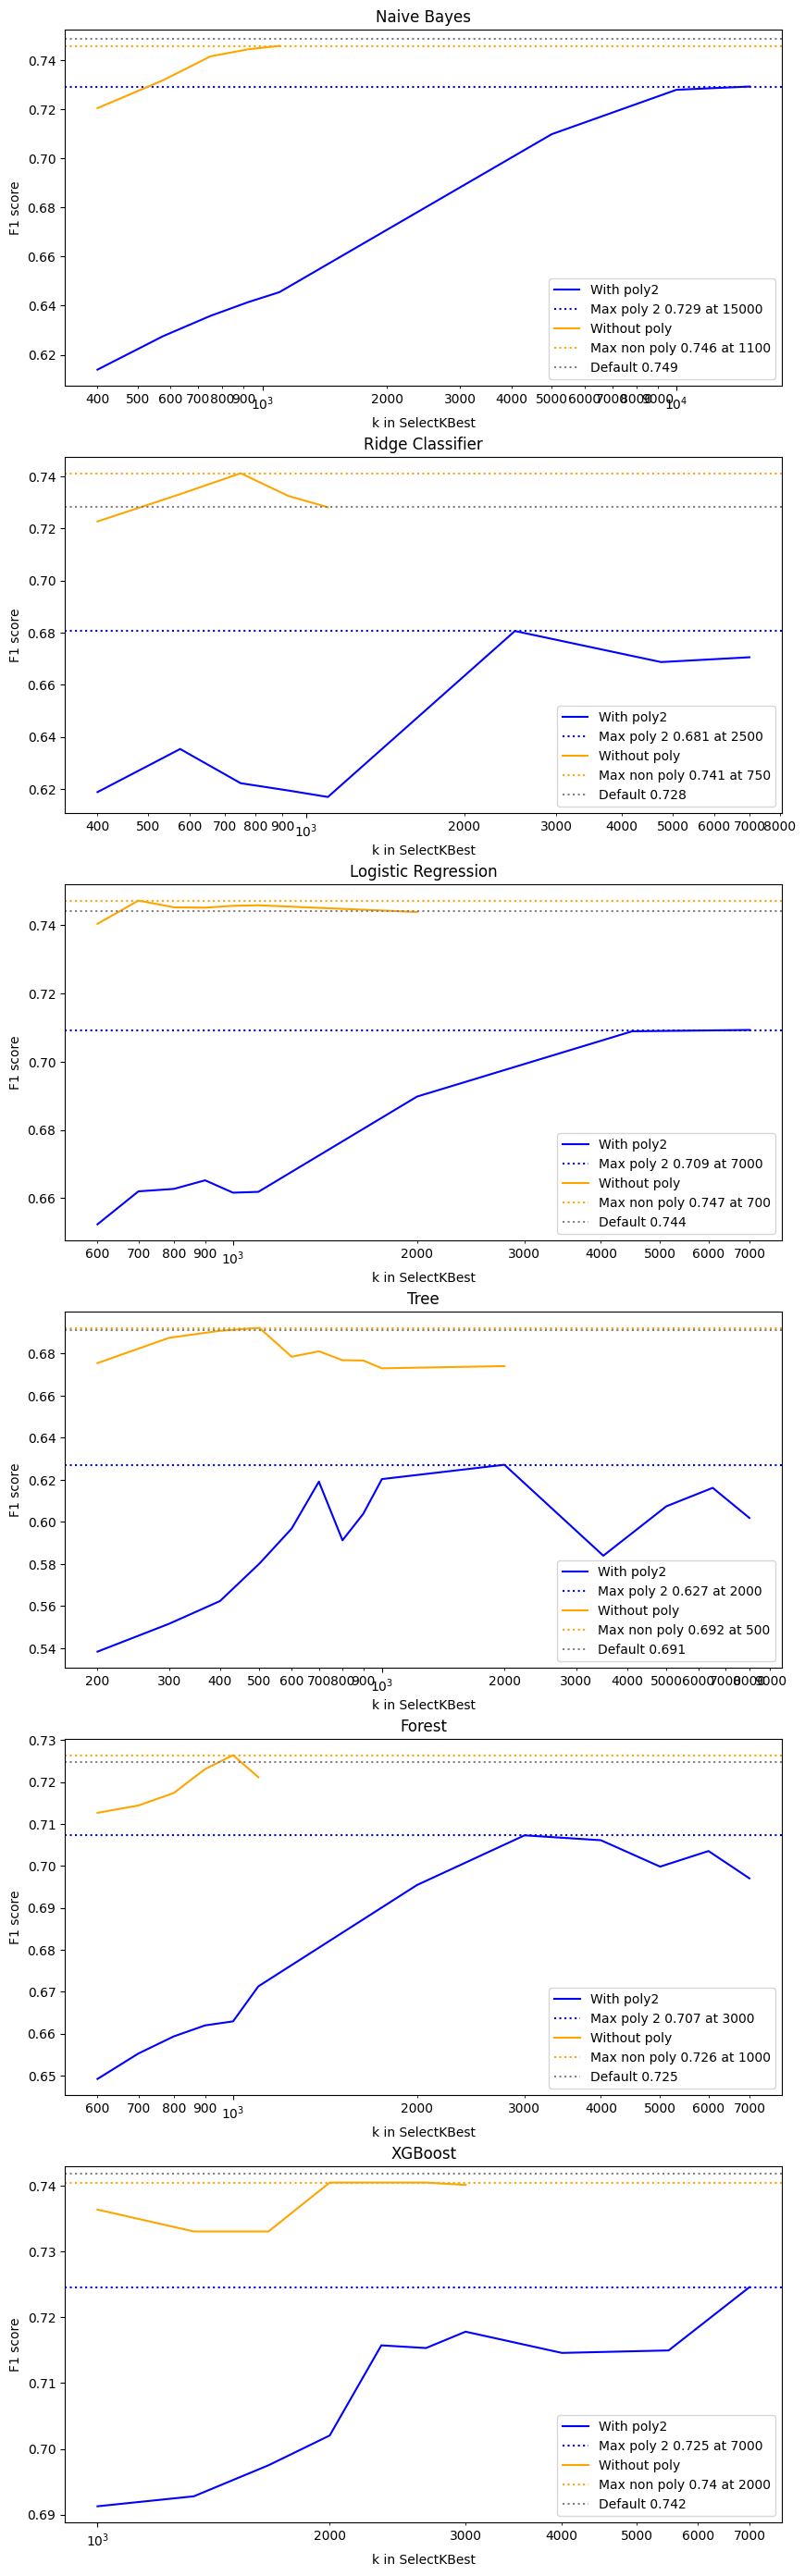

In [131]:
plot_k_range_results(xgb_tree_results)

### TruncatedSVD
* TruncatedSVD is a linear dimensionality reduction technique similar to PCA, but capable of working with sparce matrices 
* We are going to apply TruncatedSVD on the best results from the previous steps.
* The tuples below reflect the best found values for k for non-poly and poly2 cases
* There's an addition option: Poly2 + BestK 10000. The idea of adding it is to check the hypothesis that SelectBestK when set to too low k might cut some interesting features that might be picked up by TruncatedSVD  

In [135]:
%%time

best_k_dict = {
    Models.rc_key: (750, 2500),
    Models.lr_key: (700, 7000),
    Models.tree_key: (500, 2000),
    Models.forest_key: (1000, 3000),
    Models.xgb_key: (2000, 7000)
}

svd_params_dict = {
    key: {
        'pipe': pipe_with_transformations(key),
        'n_range': np.linspace(100, 1000, 10, dtype=int),
        'no_poly_k': best_k[0],
        'poly_2_k': best_k[1],
        'cv': cv,
        'X': X_full_train,
        'y': y_full_train
    } for key, best_k in best_k_dict.items()
}
    
svd_n_range_results = svd_n_range_scores(svd_params_dict)

Started Ridge Classifier at 01:05:53
Started Logistic Regression at 01:20:03
Started Tree at 02:43:25
Started Forest at 03:51:16
Started XGBoost at 04:08:51
CPU times: user 8h 5min 13s, sys: 1h 32min 37s, total: 9h 37min 51s
Wall time: 4h 44min 48s


In [153]:
all_preparation_params[best_preparation_params[Models.lr_key]]

{'kw': True, 'hashtags': True}

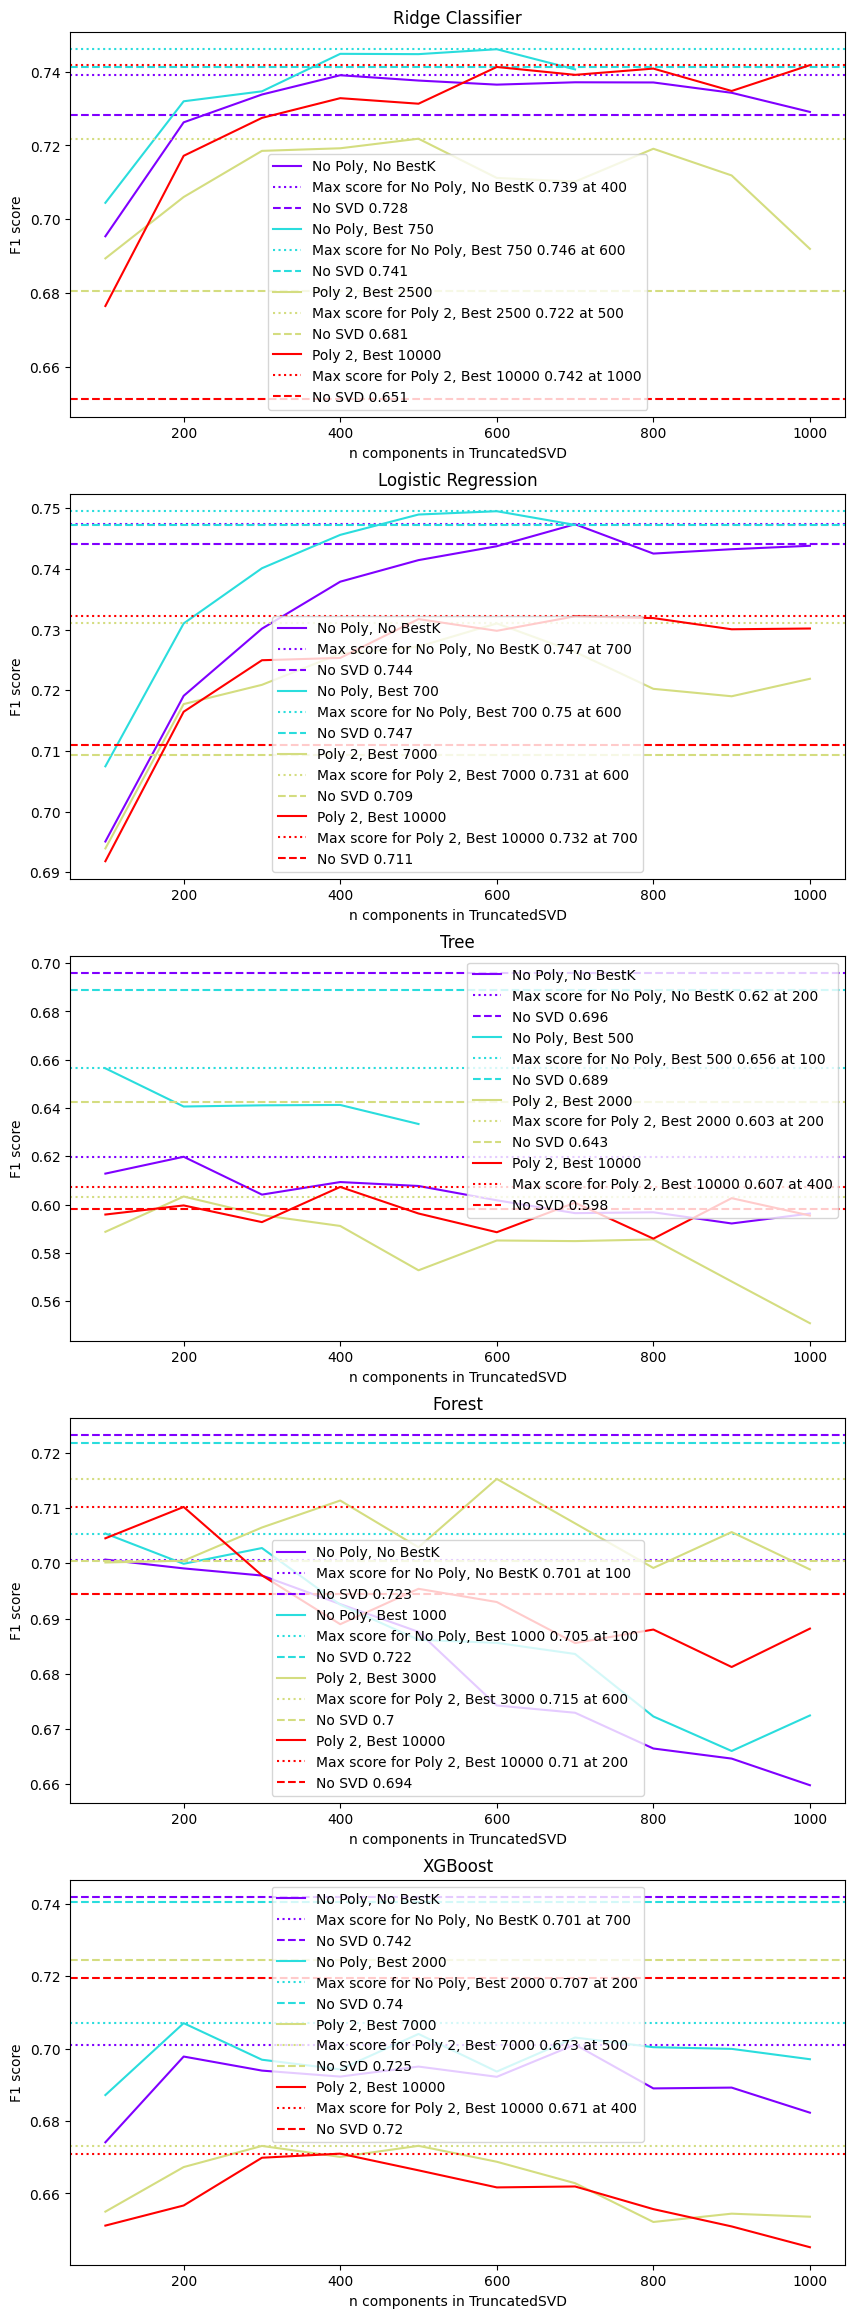

In [136]:
plot_svd__range_results(svd_n_range_results)

### Best transformation parameters and scores

In [247]:
best_transformation_params = {
    Models.nb_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.rc_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 750, 'svd__n_components': 600},
    Models.lr_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 700, 'svd__n_components': 600},
    Models.tree_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.forest_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.xgb_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'}
}

def make_best_transformation_pipeline(key):
    pipeline = pipe_with_transformations(key)

    pipeline.set_params(**(best_transformation_params[key]))
    return pipeline    

In [248]:
best_transformation_pipelines = {
    key: make_best_transformation_pipeline(key) for key in best_transformation_params.keys()
}

In [249]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    transformation_scores_df = evaluate_pipelines(best_transformation_pipelines, feature_key='Data transformation')

CPU times: user 1min 30s, sys: 1min 40s, total: 3min 11s
Wall time: 44.1 s


In [250]:
pd.concat((default_scores_df, preparation_scores_df, transformation_scores_df))

Naive Bayes  Ridge Classifier  \
Features                                                     
Default (x_val)                 0.733873          0.721860   
Default (test)                  0.760383          0.758837   
Data preparation (x_val)        0.748595          0.728327   
Data preparation (test)         0.773688          0.762805   
Data transformation (x_val)     0.748595          0.745575   
Data transformation (test)      0.773688          0.739921   

                             Logistic Regression      Tree    Forest   XGBoost  
Features                                                                        
Default (x_val)                         0.734567  0.657304  0.700060  0.736132  
Default (test)                          0.762422  0.681388  0.725849  0.742475  
Data preparation (x_val)                0.744144  0.694481  0.723960  0.741877  
Data preparation (test)                 0.767677  0.709930  0.731466  0.759367  
Data transformation (x_val)             0.749581  0.692153  0.724453  0.741877  
Data transformation (test)              0.746057  0.705517  0.721615  0.759367

## Final Models Parameters Tuning
* Now based on the optimized pipelines I'll do the hyperparameter tuning for each model
* The general routine will consist of consecutive steps like follows:
    * Keep best results from previous step
    * Optimize next another paramater doing search along a range of values 

In [141]:
def grid_search_fast(pipe, param_grid, X, y):
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv_fast) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [142]:
def grid_search(pipe, param_grid, X, y):
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [143]:
from preprocess_util import plot_grid_results

In [145]:
best_fine_tuning_params = {}

### Naive Bayes

Tuned Hyperparameters : {'classifier__alpha': 1.0}
F1 score : 0.7485948560615903
________________________
CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.78 s


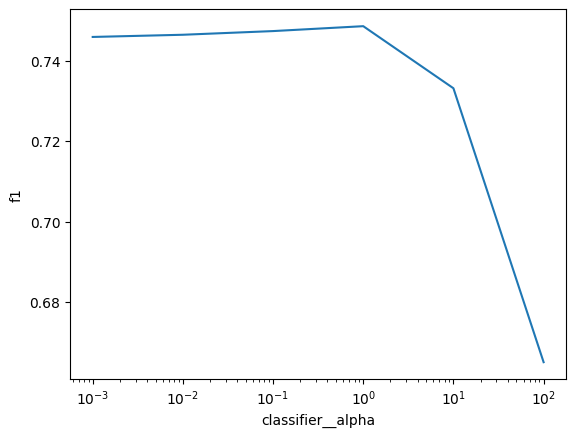

In [146]:
%%time

nb_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6)
}

nb_tuning_results = grid_search(make_best_transformation_pipeline(Models.nb_key), nb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(nb_tuning_results, 'classifier__alpha', log=True)

In [179]:
best_fine_tuning_params[Models.nb_key] = {
    'classifier__alpha': 1.0
}

### Ridge Classifier

In [199]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6),
    'classifier__solver': ['lsqr', 'saga', 'sag', 'auto'],
}

rc_tuning_results = grid_search(make_best_transformation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__alpha': 10.0, 'classifier__solver': 'lsqr'}
F1 score : 0.7474233944755012
________________________
CPU times: user 10min 39s, sys: 10min 23s, total: 21min 3s
Wall time: 4min 38s


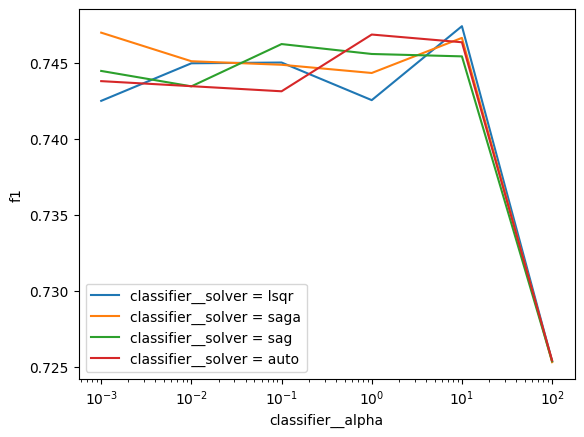

In [200]:
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver', log=True)

In [208]:
best_fine_tuning_params[Models.rc_key] = {
    # 'classifier__alpha': 0.1,
    # 'classifier__solver': 'sag'
}

### Logistic Regression

In [149]:
%%time

lr_tuning_grid = {
    'classifier__C': np.logspace(-3,2,6),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

lr_tuning_results = grid_search(make_best_transformation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__solver': 'lbfgs'}
F1 score : 0.750458415119907
________________________
CPU times: user 11min 45s, sys: 8min 51s, total: 20min 37s
Wall time: 6min 22s


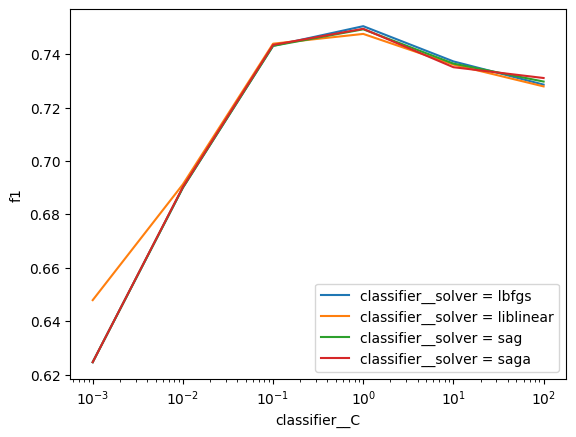

In [150]:
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver', log=True)

In [151]:
best_fine_tuning_params[Models.lr_key] = {
    'classifier__C': 1.0
}

### Decision Tree

In [153]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [2, 3, 5, 10, 20, 50, 100, 120, 130, 140, 150, 170, 200, 300, None]
}

tree_tuning_results = grid_search(make_best_transformation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 140}
F1 score : 0.6989232921277797
________________________
CPU times: user 19.9 s, sys: 0 ns, total: 19.9 s
Wall time: 19.9 s


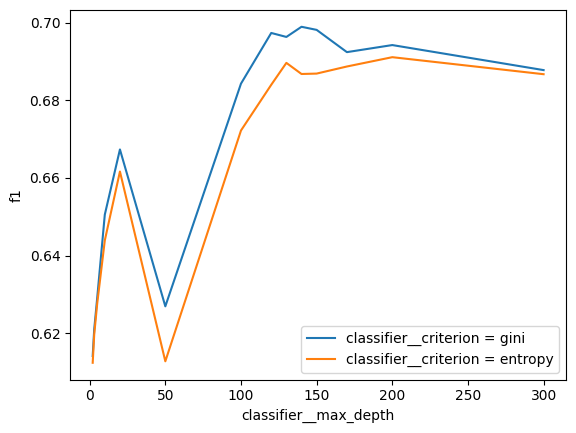

In [154]:
plot_grid_results(tree_tuning_results, 'classifier__max_depth', legend_var='classifier__criterion')

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 140, 'classifier__min_samples_leaf': 1}
F1 score : 0.698786362179809
________________________
CPU times: user 45.6 s, sys: 80.5 ms, total: 45.6 s
Wall time: 45.6 s


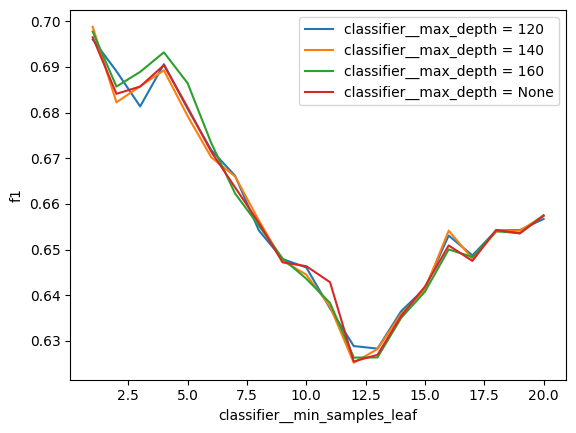

In [155]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [120, 140, 160, None],
    'classifier__min_samples_leaf': np.linspace(1, 20, 20, dtype=int)
}

tree_tuning_results = grid_search(make_best_transformation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_leaf', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 140, 'classifier__min_samples_split': 100}
F1 score : 0.7120283682948763
________________________
CPU times: user 57.2 s, sys: 32.4 ms, total: 57.3 s
Wall time: 57.3 s


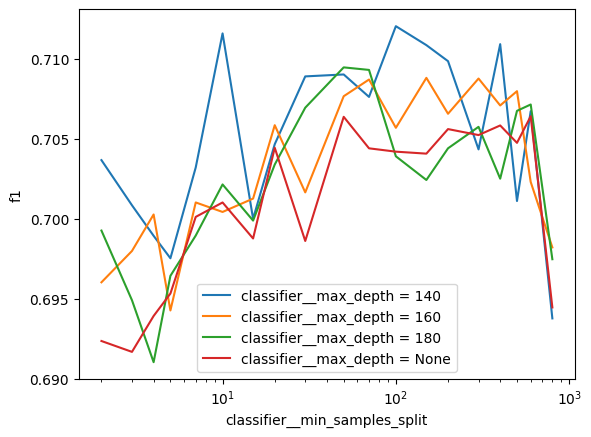

In [158]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [140, 160, 180, None],
    'classifier__min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 800]
}

tree_tuning_results = grid_search(make_best_transformation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_split', legend_var='classifier__max_depth', log=True)

In [159]:
best_fine_tuning_params[Models.tree_key] = {
    'classifier__criterion': 'gini',
    'classifier__max_depth': 140,
    'classifier__min_samples_split': 120
}

### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 100, 'classifier__n_estimators': 140}
F1 score : 0.7375408580154287
________________________
CPU times: user 6min 7s, sys: 23.2 s, total: 6min 30s
Wall time: 7min 59s


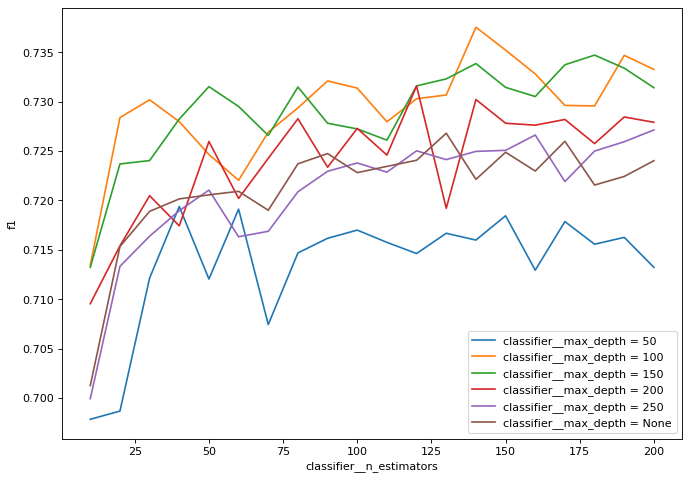

In [160]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [50, 100, 150, 200, 250, None],
    'classifier__n_estimators': np.linspace(10, 200, 20, dtype=int)
}

forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__n_estimators': 260}
F1 score : 0.7418002602951524
________________________
CPU times: user 4min 5s, sys: 18.9 s, total: 4min 24s
Wall time: 5min 47s


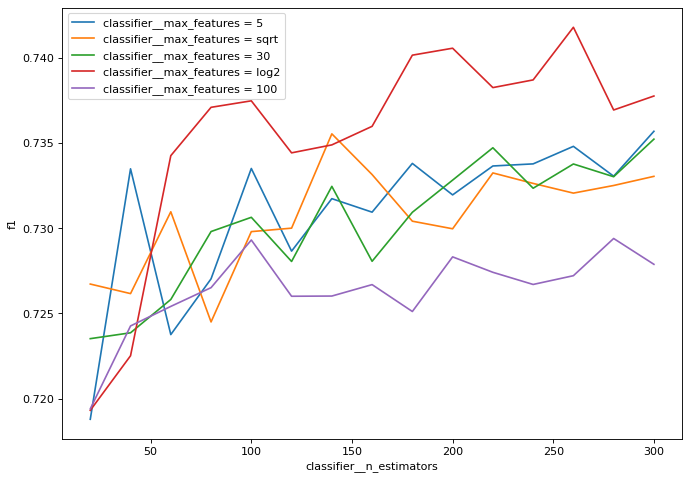

In [162]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': [5, 'sqrt', 30, 'log2', 100],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_features')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 400}
F1 score : 0.7562336422885074
________________________
CPU times: user 5min 50s, sys: 36.5 s, total: 6min 27s
Wall time: 6min 45s


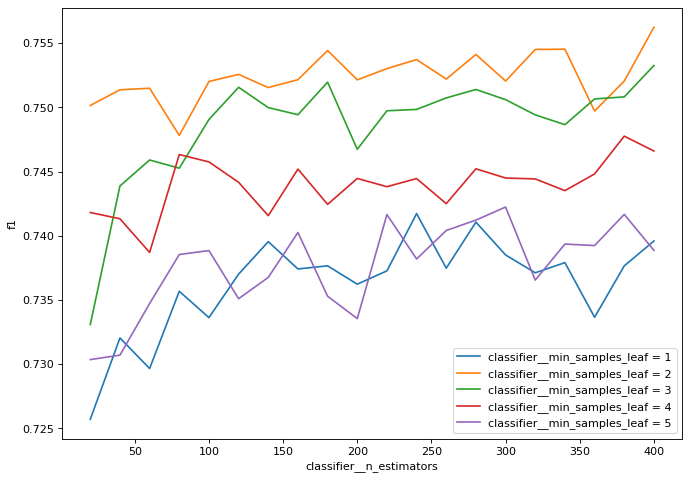

In [165]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'classifier__n_estimators': np.linspace(20, 400, 20, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_leaf')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 200, 'classifier__n_estimators': 150}
F1 score : 0.757081602769459
________________________
CPU times: user 1min 33s, sys: 8.37 s, total: 1min 41s
Wall time: 1min 40s


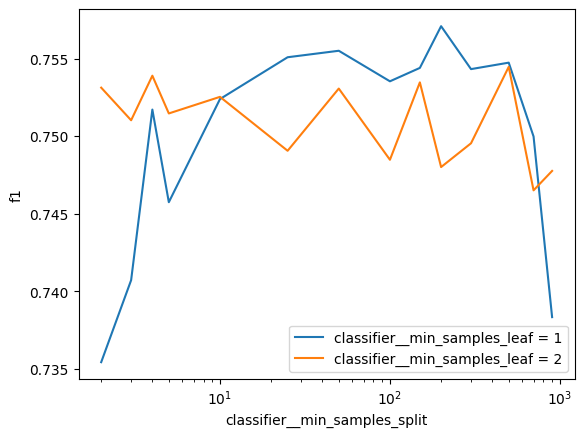

In [166]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2],

    'classifier__min_samples_split': [2, 3, 4, 5, 10, 25, 50, 100, 150, 200, 300, 500, 700, 900],
    'classifier__n_estimators': [150]
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
plot_grid_results(forest_tuning_results, 'classifier__min_samples_split', legend_var='classifier__min_samples_leaf', log=True)

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 140, 'classifier__n_estimators': 220}
F1 score : 0.7580651126734524
________________________
CPU times: user 2min 17s, sys: 12.6 s, total: 2min 29s
Wall time: 2min 25s


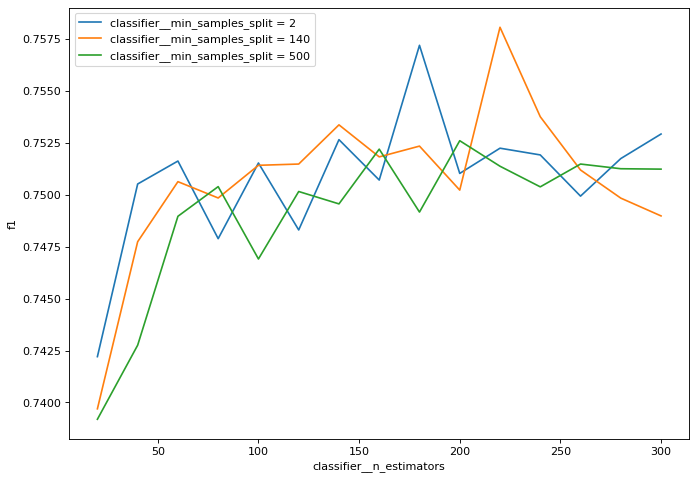

In [167]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [2],
    'classifier__min_samples_split': [2, 140, 500],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 500, 'classifier__n_estimators': 160}
F1 score : 0.7546616553101
________________________
CPU times: user 2min 19s, sys: 12.6 s, total: 2min 31s
Wall time: 2min 32s


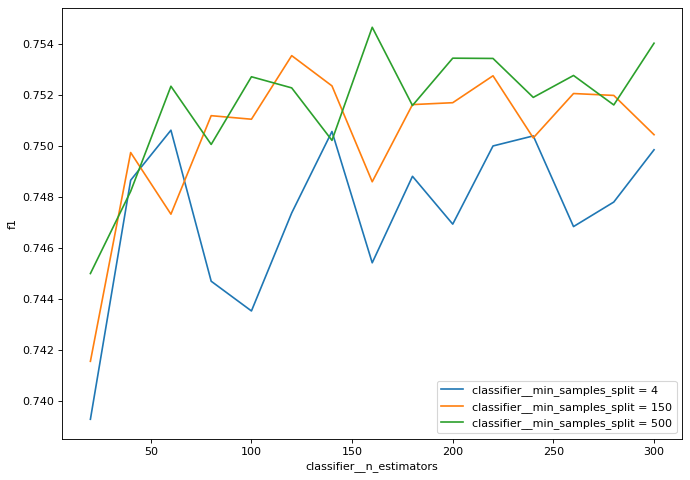

In [168]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1],
    'classifier__min_samples_split': [4, 150, 500],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

In [169]:
best_fine_tuning_params[Models.forest_key] =  {
    'classifier__max_depth': 150,
    'classifier__max_features': 'log2',
    'classifier__min_samples_leaf': 2,
    'classifier__n_estimators': 140
}

### XGBoost

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
________________________
CPU times: user 36min 57s, sys: 9.57 s, total: 37min 6s
Wall time: 6min 55s


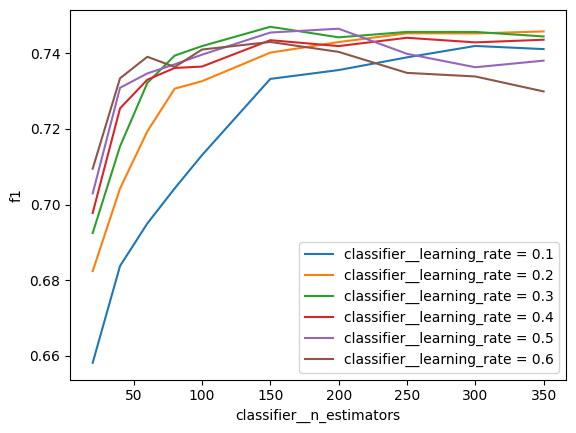

In [170]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

xgb_tuning_results = grid_search(make_best_transformation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__learning_rate')

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
________________________
CPU times: user 28min 2s, sys: 6.63 s, total: 28min 9s
Wall time: 5min 46s


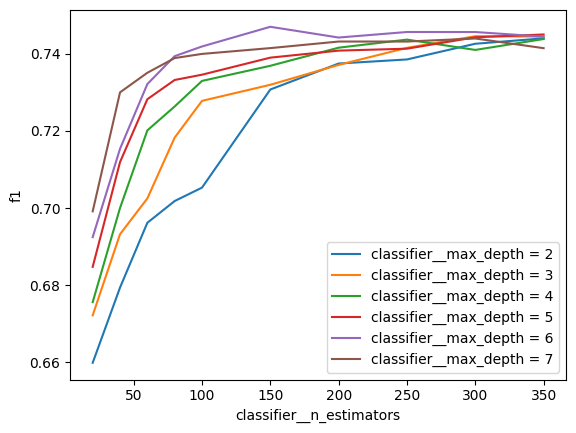

In [171]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7]
}

xgb_tuning_results = grid_search(make_best_transformation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
________________________
CPU times: user 25min 43s, sys: 5.84 s, total: 25min 49s
Wall time: 5min 25s


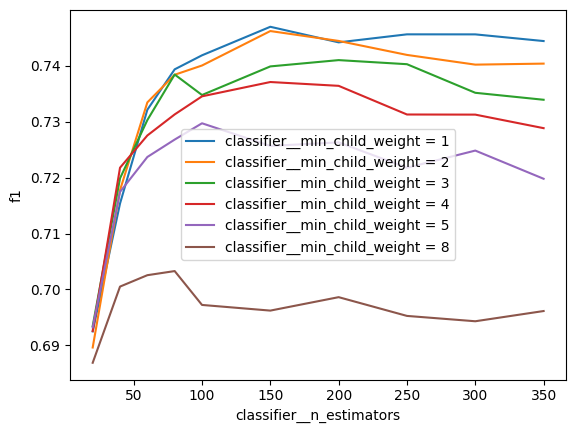

In [172]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [6],
    'classifier__min_child_weight': [1, 2, 3, 4, 5, 8]
}

xgb_tuning_results = grid_search(make_best_transformation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_child_weight')

In [173]:
best_fine_tuning_params[Models.xgb_key] = {
    'classifier__n_estimators': 150,    
    'classifier__learning_rate': 0.3,
    'classifier__max_depth': 6,
    'classifier__min_child_weight': 1
}

### Best fine tuning score

In [202]:
def make_best_fine_tuned_pipeline(key):
    pipeline = make_best_transformation_pipeline(key)

    pipeline.set_params(**(best_fine_tuning_params[key]))
    return pipeline    

In [220]:
best_fine_tuning_pipelines = {
    key: make_best_transformation_pipeline(key) for key in [Models.rc_key]# best_fine_tuning_params.keys()
}

In [221]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fine_tuning_scores_df = evaluate_pipelines(best_fine_tuning_pipelines, feature_key='Fine tuning')

CPU times: user 23.4 s, sys: 24.4 s, total: 47.8 s
Wall time: 8.93 s


In [222]:
pd.concat((default_scores_df, preparation_scores_df, transformation_scores_df, fine_tuning_scores_df))

Naive Bayes  Ridge Classifier  \
Features                                                     
Default (x_val)                 0.733873          0.721860   
Default (test)                  0.760383          0.758837   
Data preparation (x_val)        0.748595          0.728327   
Data preparation (test)         0.773688          0.762805   
Data transformation (x_val)     0.748595          0.746797   
Data transformation (test)      0.773688          0.739921   
Fine tuning (x_val)                  NaN          0.747138   
Fine tuning (test)                   NaN          0.737757   

                             Logistic Regression      Tree    Forest   XGBoost  
Features                                                                        
Default (x_val)                         0.734567  0.657304  0.700060  0.736132  
Default (test)                          0.762422  0.681388  0.725849  0.742475  
Data preparation (x_val)                0.744144  0.694481  0.723960  0.741877  
Data preparation (test)                 0.767677  0.709930  0.731466  0.759367  
Data transformation (x_val)             0.749427  0.692413  0.723770  0.741877  
Data transformation (test)              0.747443  0.705148  0.727578  0.759367  
Fine tuning (x_val)                          NaN       NaN       NaN       NaN  
Fine tuning (test)                           NaN       NaN       NaN       NaN

In [211]:
print(best_transformation_pipelines[Models.rc_key].named_steps)

{'url_cleaner': None, 'vectorizer': ColumnTransformer(transformers=[('text_c_vect',
                                 CountVectorizer(min_df=10,
                                                 preprocessor=<function stem_preprocessor at 0x7f6428c09630>,
                                                 stop_words=['i', 'me', 'my',
                                                             'myself', 'we',
                                                             'our', 'ours',
                                                             'ourselves', 'you',
                                                             "you're", "you've",
                                                             "you'll", "you'd",
                                                             'your', 'yours',
                                                             'yourself',
                                                             'yourselves', 'he',
                                         

In [212]:
print(best_fine_tuning_pipelines[Models.rc_key].named_steps)

{'url_cleaner': None, 'vectorizer': ColumnTransformer(transformers=[('text_c_vect',
                                 CountVectorizer(min_df=10,
                                                 preprocessor=<function stem_preprocessor at 0x7f6428c09630>,
                                                 stop_words=['i', 'me', 'my',
                                                             'myself', 'we',
                                                             'our', 'ours',
                                                             'ourselves', 'you',
                                                             "you're", "you've",
                                                             "you'll", "you'd",
                                                             'your', 'yours',
                                                             'yourself',
                                                             'yourselves', 'he',
                                         

In [470]:
%%time
again_df = pd.DataFrame()
for prep_key, prep_params in all_preparation_params.items():
    pipelines = {}
    for key in best_fine_tuning_params.keys():
        print (f'Doing {key}')
        pipeline = make_preparation_pipeline(**prep_params) 
        classifier = make_model(key)
        steps = pipeline.steps.copy()
        steps.append(('poly2_k_best', make_poly2_k_best_pipeline()))
        steps.append(('svd', TruncatedSVD()))
        steps.append(('classifier', classifier))
        pipeline = Pipeline(steps)
        pipeline.set_params(**(best_transformation_params[key]))
        pipeline.set_params(**(best_fine_tuning_params[key]))
        pipelines[key] = pipeline
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        %time again_df = pd.concat((again_df, evaluate_pipelines(pipelines, feature_key=prep_key)))

Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 2s, sys: 1min 57s, total: 4min
Wall time: 42.5 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 17s, sys: 2min, total: 4min 18s
Wall time: 58.6 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 3min 57s, sys: 1min 59s, total: 5min 57s
Wall time: 2min 32s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 7s, sys: 2min 9s, total: 4min 16s
Wall time: 43.8 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 18s, sys: 2min 21s, total: 4min 40s
Wall time: 47.2 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU 

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1683; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1709; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1716; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1703; got 1750. Use k='all' to return all features.


Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 3min 43s, sys: 2min 2s, total: 5min 45s
Wall time: 2min 30s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 1min 58s, sys: 2min 14s, total: 4min 12s
Wall time: 43.2 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 22s, sys: 2min 8s, total: 4min 30s
Wall time: 59.5 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 1min 45s, sys: 1min 44s, total: 3min 29s
Wall time: 36.1 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 1min 56s, sys: 2min 3s, total: 3min 59s
Wall time: 41.4 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBo

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1680; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1707; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1714; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1700; got 1750. Use k='all' to return all features.


Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 23s, sys: 2min 13s, total: 4min 36s
Wall time: 1min 3s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 35s, sys: 2min 37s, total: 5min 12s
Wall time: 52.4 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 12s, sys: 2min 20s, total: 4min 32s
Wall time: 47.2 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 39s, sys: 3min, total: 5min 39s
Wall time: 55.9 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 46s, sys: 2min 41s, total: 5min 28s
Wall time: 1min 9s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoo

In [475]:
again_diffs = again_df - fine_tuning_scores_df.loc['Fine tuning (x_val)']

In [486]:
again_diffs = again_diffs[again_diffs.index.str.contains('val')]

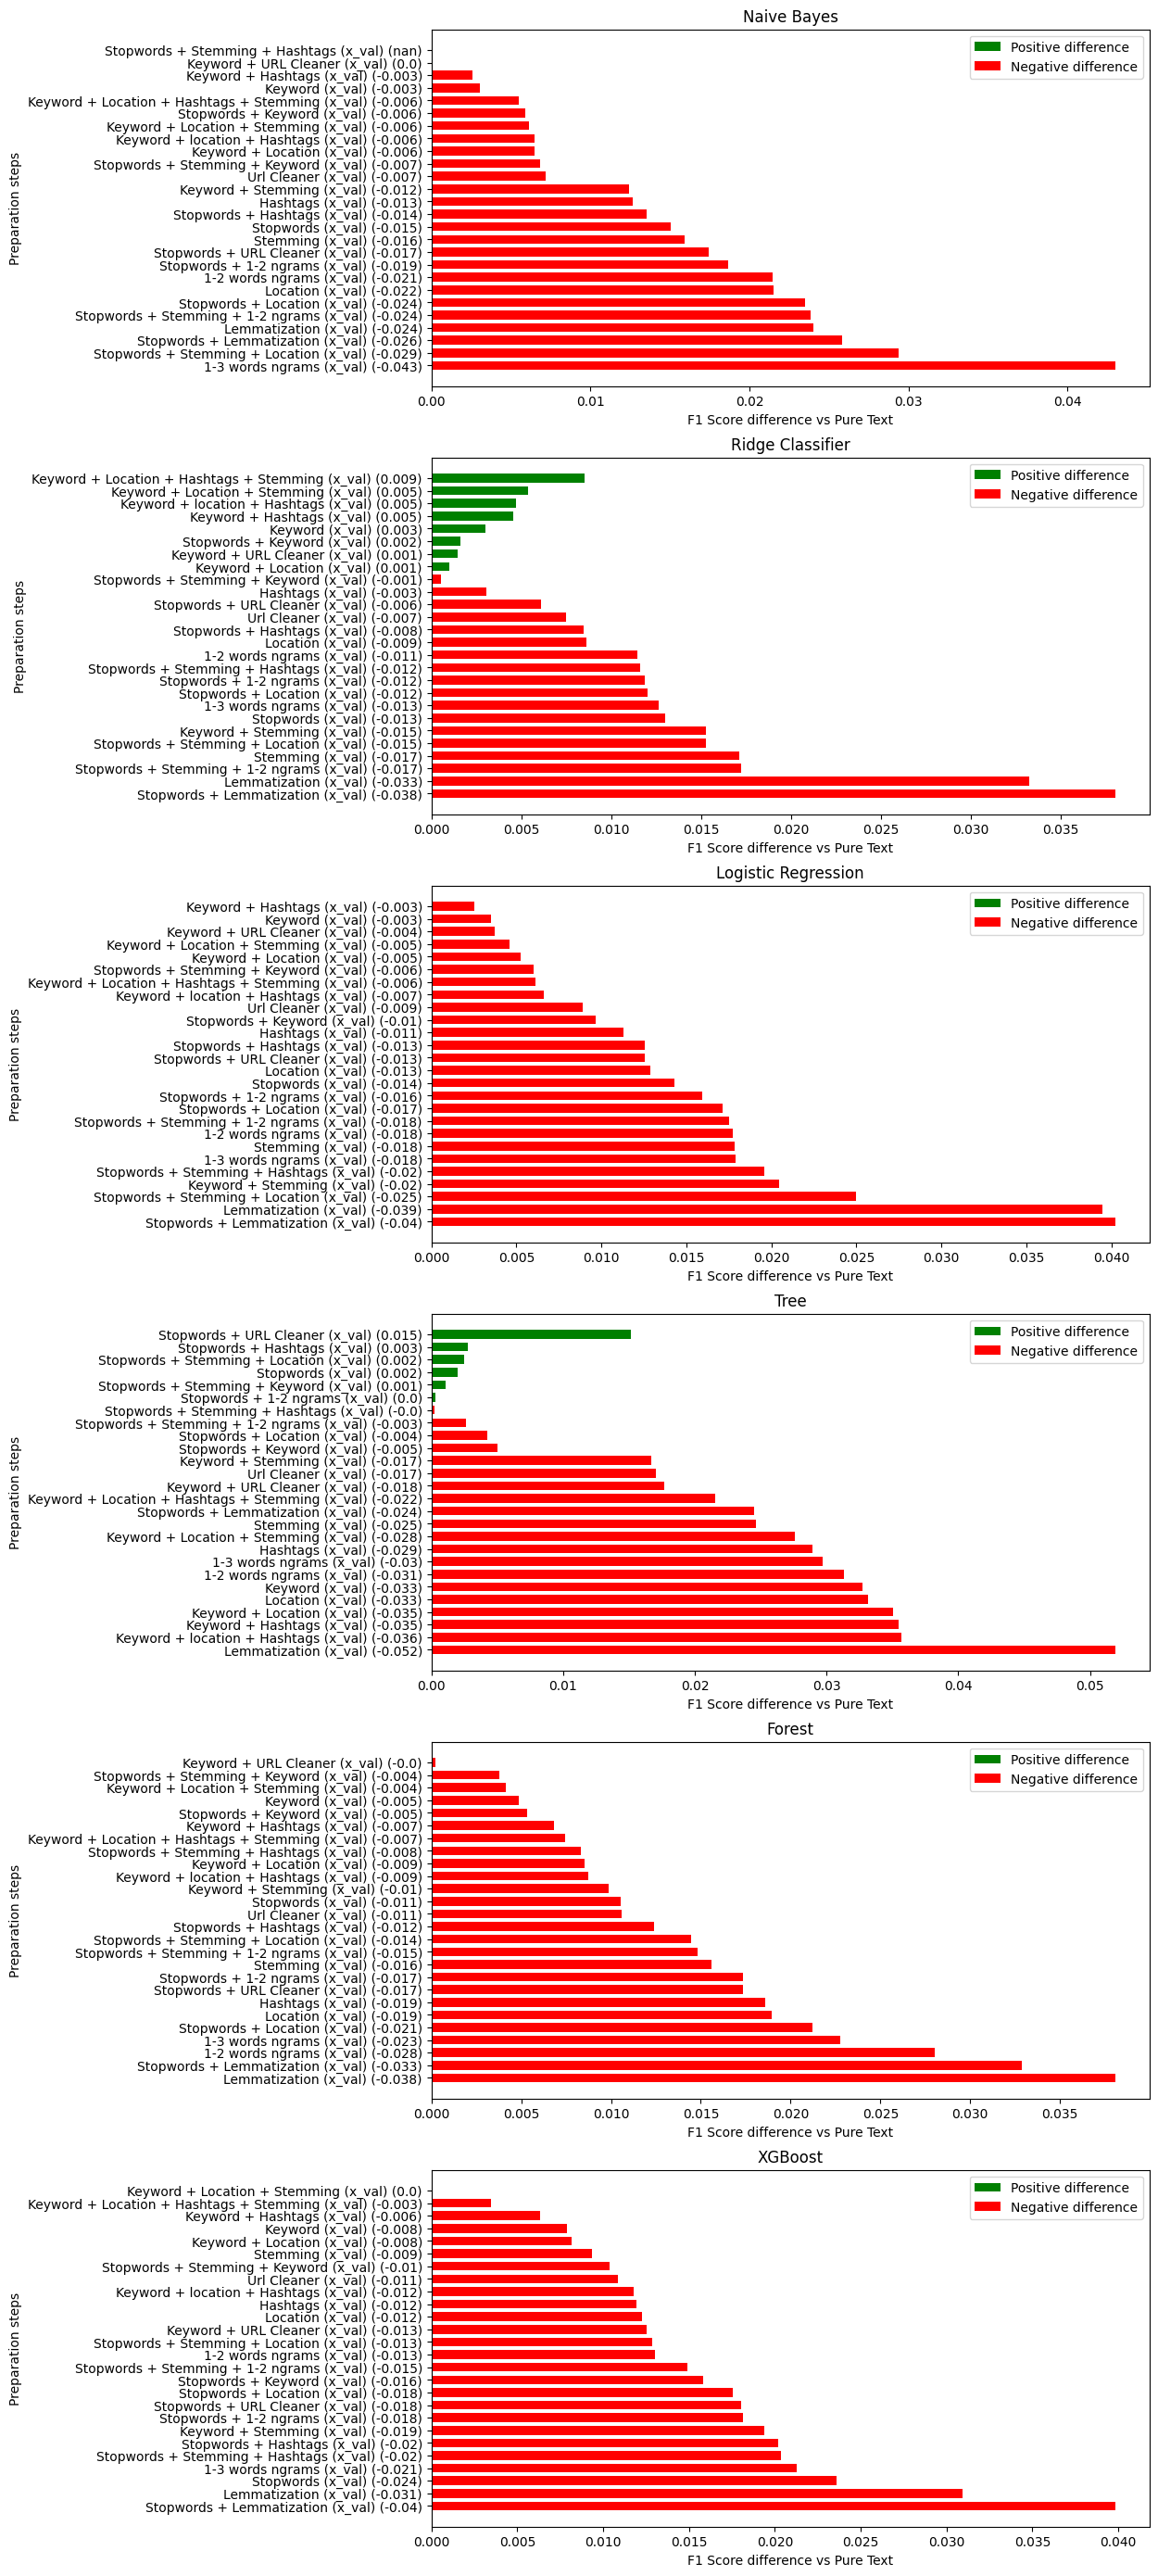

In [487]:
plot_score_diffs(again_diffs)

In [488]:
best_again_params = again_diffs.idxmax()
best_again_params

Naive Bayes                               Keyword + URL Cleaner (x_val)
Ridge Classifier       Keyword + Location + Hashtags + Stemming (x_val)
Logistic Regression                          Keyword + Hashtags (x_val)
Tree                                    Stopwords + URL Cleaner (x_val)
Forest                                    Keyword + URL Cleaner (x_val)
XGBoost                           Keyword + Location + Stemming (x_val)
dtype: object

In [ ]:
best_again_pipelines = {
    key: all_preparation_pipelines[params_key] for key, params_key in best_preparation_params.items()
}

## Train and test winner models

In [79]:
%%time
train_data_sag = prepare_data_tkl_poly(df_full_train, svd_n_components=1000)
test_data_sag = prepare_test_data_tkl_poly(df_test, train_data_sag)

CPU times: user 1h 23min 39s, sys: 16min 1s, total: 1h 39min 40s
Wall time: 1h 38min 10s


In [80]:
stemmer.stem('blown')

'blown'

In [81]:
%%time
model_lr_sag = LogisticRegression(solver="sag", C=1.0, max_iter=1000, random_state=42)
model_lr_sag.fit(train_data_sag['vectors'], df_full_train.target)
f1_score(df_test.target, model_lr_sag.predict(test_data_sag))

CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.4 s


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7613542526837325

In [82]:
%%time
train_data_rc = prepare_data_tkl_poly(df_full_train, svd_n_components=700)
test_data_rc = prepare_test_data_tkl_poly(df_test, train_data_rc)

CPU times: user 2min 44s, sys: 29.8 s, total: 3min 14s
Wall time: 2min 10s


In [83]:
%%time
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_rc.fit(train_data_rc['vectors'], df_full_train.target)
f1_score(df_test.target, model_rc.predict(test_data_rc))

CPU times: user 58.9 ms, sys: 235 ms, total: 294 ms
Wall time: 77.1 ms


0.7491909385113268

Stemmer + stopwords: 0.76, 0.75

Stemmer: 0.76, 0.75

Stopwords: 0.75, 0.74

Plain: 0.74, 0.75

Lemma: 0.75, 0.74

In [85]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model_lr = LogisticRegression(max_iter=500, random_state=42)
grids_lr = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr[scoring] = clf

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8213453718411428
________________________
Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
f1 : 0.7749059682772194
________________________
Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
roc_auc : 0.880072438164868
________________________
CPU times: user 44min 28s, sys: 6min 32s, total: 51min 1s
Wall time: 38min 41s


In [86]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']
parameters = {
    'alpha': [0.1, 0.5, 1, 2, 3, 4],
    'solver': ['lsqr', 'saga', 'sag'],
}

model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
grids_rc = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_rc,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_rc[scoring] = clf

Tuned Hyperparameters : {'alpha': 0.5, 'solver': 'saga'}
accuracy : 0.8164196943407395
________________________
Tuned Hyperparameters : {'alpha': 2, 'solver': 'sag'}
f1 : 0.7745214652653776
________________________
Tuned Hyperparameters : {'alpha': 4, 'solver': 'saga'}
roc_auc : 0.8777037458819706
________________________
CPU times: user 21min 22s, sys: 1min 20s, total: 22min 43s
Wall time: 20min 5s


In [92]:
pd.DataFrame(grids_rc['accuracy'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

param_alpha param_solver  mean_test_score  std_test_score
0          0.1         lsqr         0.805582        0.009981
1          0.1         saga         0.816255        0.008197
2          0.1          sag         0.814121        0.008179
3          0.5         lsqr         0.805582        0.009981
4          0.5         saga         0.816420        0.008249
5          0.5          sag         0.814121        0.008179
6            1         lsqr         0.806074        0.009921
7            1         saga         0.816255        0.008197
8            1          sag         0.814121        0.008179
9            2         lsqr         0.806731        0.008809
10           2         saga         0.815927        0.007534
11           2          sag         0.815598        0.007671
12           3         lsqr         0.807388        0.008894
13           3         saga         0.815927        0.007362
14           3          sag         0.815270        0.007674
15           4         lsqr         0.807059        0.008520
16           4         saga         0.816256        0.007649
17           4          sag         0.815270        0.007674

In [93]:
pd.DataFrame(grids_rc['f1'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

param_alpha param_solver  mean_test_score  std_test_score
0          0.1         lsqr         0.764547        0.015062
1          0.1         saga         0.773567        0.012115
2          0.1          sag         0.772884        0.012035
3          0.5         lsqr         0.764547        0.015062
4          0.5         saga         0.773725        0.012135
5          0.5          sag         0.772884        0.012035
6            1         lsqr         0.764989        0.015170
7            1         saga         0.773475        0.012106
8            1          sag         0.772794        0.012061
9            2         lsqr         0.765753        0.014674
10           2         saga         0.772993        0.011165
11           2          sag         0.774521        0.012127
12           3         lsqr         0.766659        0.014458
13           3         saga         0.772907        0.010848
14           3          sag         0.774021        0.012262
15           4         lsqr         0.766207        0.013617
16           4         saga         0.773139        0.010962
17           4          sag         0.774021        0.012262

In [94]:
pd.DataFrame(grids_rc['roc_auc'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

param_alpha param_solver  mean_test_score  std_test_score
0          0.1         lsqr         0.867089        0.013634
1          0.1         saga         0.877488        0.011419
2          0.1          sag         0.875830        0.012074
3          0.5         lsqr         0.867272        0.013593
4          0.5         saga         0.877515        0.011381
5          0.5          sag         0.875883        0.012060
6            1         lsqr         0.867473        0.013526
7            1         saga         0.877542        0.011338
8            1          sag         0.875950        0.012024
9            2         lsqr         0.867985        0.013486
10           2         saga         0.877580        0.011264
11           2          sag         0.876080        0.011967
12           3         lsqr         0.868385        0.013407
13           3         saga         0.877671        0.011206
14           3          sag         0.876197        0.011895
15           4         lsqr         0.868832        0.013163
16           4         saga         0.877704        0.011131
17           4          sag         0.876287        0.011828

In [1]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}

model_lr_big = LogisticRegression(max_iter=1000, random_state=42)
grids_lr_big = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_sag['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr_big[scoring] = clf

NameError: name 'LogisticRegression' is not defined

In [96]:
current_time = datetime.now().strftime("%H:%M:%S")
print("Time finished =", current_time)

Time finished = 18:58:05
